In [58]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import 

### Simple data cleaning

In [34]:
FULL_DATA = 'data/training.1600000.processed.noemoticon.csv'
cols = ['sentiment', 'id', 'date', 'query_string', 'user', 'text']
df_full = pd.read_csv(FULL_DATA, names=cols, encoding='latin-1')

In [35]:
df_full.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Target is sentiment. 0 for negative 4 for positive -> transforming into 0 and 1

In [36]:
df_full.sentiment.unique()

array([0, 4], dtype=int64)

In [50]:
df_full['target'] = df_full['sentiment'].apply(lambda x: 1 if x==4 else 0)

Query string is constant, can be dropped

In [39]:
df_full.query_string.unique()

array(['NO_QUERY'], dtype=object)

Retaining user for data exploratory purposes

In [51]:
df_processed = df_full[['user', 'text', 'target']]

In [52]:
df_processed.head()

,user,text,target
0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,scotthamilton,is upset that he can't update his Facebook by ...,0
2,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,ElleCTF,my whole body feels itchy and like its on fire,0
4,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [53]:
df_processed.target.unique()

array([0, 1], dtype=int64)

In [54]:
df_processed.user.unique()

array(['_TheSpecialOne_', 'scotthamilton', 'mattycus', ..., 'EvolveTom',
       'AmandaMarie1028', 'bpbabe'], dtype=object)

### Exploratory Analysis

#### Users

In [67]:
len(df_processed.user.unique())

659775

In [63]:
users_tweets = df_processed.groupby('user')['target'].count().sort_values()
users_tweets

user
dancelikejordan      1
havin_an_affair      1
havicyeo             1
haveyoumettony       1
havetoexplode        1
                  ... 
VioletsCRUK        279
SallytheShizzle    281
tweetpet           310
webwoke            345
lost_dog           549
Name: target, Length: 659775, dtype: int64

Only 22k users out of 660k post 10 or more tweets

In [68]:
sum(users_tweets >= 10)

21875

Many users are extreme? i.e. always posting positive or negative comments

In [73]:
heavy_users = users_tweets[users_tweets >= 10].index
df_heavy_users = df_processed[df_processed.user.isin(heavy_users)][['user', 'target']]

In [80]:
polarities = df_heavy_users.groupby('user')['target'].sum() / df_heavy_users.groupby('user')['target'].count()

Text(0.5, 1.0, 'User Polarity')

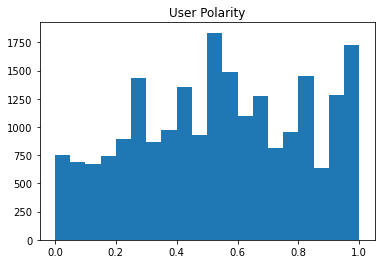

In [83]:
plt.hist(polarities, bins=20)
plt.title('User Polarity')

No clear evidence of users tending to be always positive or always negative

### Text data processing (some parts should be considered improvements and should go after Baseline)

Emoji Processing

In [86]:
# TODO: check if tweets contain emojis

User Handle Processing

In [ ]:
# TODO

Hashtag Processing

In [ ]:
# TODO

Other Processing

In [ ]:
# TODO

### Train Test Split

In [92]:
from sklearn.model_selection import train_test_split

x = df_processed.text
y = df_processed.target

SEED = 2000

#split clean data to two sets: training, validation and test
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.1, random_state=SEED)
#split the second set into two other sets : validation , test 
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))

print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))

print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))


Train set has total 1440000 entries with 49.97% negative, 50.03% positive
Validation set has total 80000 entries with 50.27% negative, 49.73% positive
Test set has total 80000 entries with 50.18% negative, 49.82% positive


### Baseline

In [95]:
# use some naive model or cite previous paper? 
# 1. use some naive model - like sentiment lexicon and classify positive if most words are positive
# - pros: can replicate
# 2. use previous research results
# - concerns: may not be able to find original source code to replicate baseline results

#### TwitrRatr - same baseline as https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf

In [97]:
# TODO : CANNOT FIND LIST OF POSITIVE/NEGATIVE WORDS MENTIONED IN THE PAPER???